# Pet Adoption Speed - Classification

In [30]:
# import the libraries

%matplotlib inline

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# sklearn :: models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# sklearn :: evaluation metrics
from sklearn.metrics import cohen_kappa_score

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')

________________________
# Load Data

In [31]:
df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [32]:
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,1,â¥â¥â¥ Lily â¥â¥â¥,36,307,0,2,2,7,0,2,...,1,1,0,41326,337914b09c2fa5460e195197e994ef98,0,Adorable 3 year old Lily looking for a forever...,3f8824a3b,1.00,4
1,2,Cookie,3,266,0,1,6,7,0,2,...,1,1,0,41327,4bb1ebb92158078ad54a6bb23c10dffc,0,i rescue this stary kitten from market near my...,9238eb7fc,1.00,2
2,2,Favour Speedy Abundance And Courage,7,250,252,1,1,2,0,2,...,1,4,0,41327,99ba8ce53b4d8515e417e7921563d923,0,The mother was a Burmese cross and had since p...,f0a1f2b90,2.00,4
3,1,NaN,3,307,0,1,2,0,0,3,...,1,1,0,41327,3f3ef74c486beba3bc87f6dbaee772bf,0,This puppy is: 1. Male 2. 3 months old 3. Brow...,7d028bdea,4.00,2
4,2,Abandoned Kitty,1,266,0,1,1,6,7,1,...,1,1,0,41401,844f03ab8054007d4be6686f3a9702b9,0,Mother cat gave birth to a litter of 3 and too...,8377bfe97,0.00,2


____________________________
# Data Cleaning

In [33]:
def change_values(df):
    
    yes_no_columns = ['Vaccinated', 'Dewormed', 'Sterilized']
    df[yes_no_columns] = df[yes_no_columns].replace(to_replace = [1,2,3], value=['Yes', 'No', 'Not_Sure'])
                                                    
    df['Gender'] = df['Gender'].replace(to_replace = [1,2,3], value=['Male','Female','Mixed'])
    df['Type'] = df['Type'].replace(to_replace = [1,2], value=['Dog', 'Cat'])
    df['MaturitySize'] = df['MaturitySize'].replace(to_replace = [1,2,3,4,0],
                                                     value=['Small', 'Medium','Large','Extra_Large','Not_Specified'])
    df['Health'] = df['Health'].replace(to_replace = [1,2,3,0], value=['Healthy', 'Minor_Injury', 'Serious_Injury','Not_Specified'])

In [34]:
change_values(df)
df[['Vaccinated', 'Dewormed', 'Sterilized', 'Type', 'Gender','MaturitySize','Health']].head(10)

,Vaccinated,Dewormed,Sterilized,Type,Gender,MaturitySize,Health
0,Yes,No,Yes,Dog,Female,Medium,Healthy
1,No,Yes,No,Cat,Male,Medium,Healthy
2,Yes,Yes,No,Cat,Male,Medium,Healthy
3,No,No,No,Dog,Male,Large,Healthy
4,No,No,No,Cat,Male,Small,Healthy
5,No,Yes,No,Dog,Male,Medium,Healthy
6,No,Yes,No,Dog,Female,Small,Healthy
7,Yes,Yes,Yes,Dog,Female,Medium,Healthy
8,No,No,No,Cat,Female,Small,Minor_Injury
9,Yes,Yes,No,Dog,Male,Small,Healthy


In [35]:
change_values(test_df)
df[['Vaccinated', 'Dewormed', 'Sterilized', 'Type', 'Gender','MaturitySize','Health']].head(10)

,Vaccinated,Dewormed,Sterilized,Type,Gender,MaturitySize,Health
0,Yes,No,Yes,Dog,Female,Medium,Healthy
1,No,Yes,No,Cat,Male,Medium,Healthy
2,Yes,Yes,No,Cat,Male,Medium,Healthy
3,No,No,No,Dog,Male,Large,Healthy
4,No,No,No,Cat,Male,Small,Healthy
5,No,Yes,No,Dog,Male,Medium,Healthy
6,No,Yes,No,Dog,Female,Small,Healthy
7,Yes,Yes,Yes,Dog,Female,Medium,Healthy
8,No,No,No,Cat,Female,Small,Minor_Injury
9,Yes,Yes,No,Dog,Male,Small,Healthy


_______________
# Missing Values

In [36]:
df.isnull().sum()

Type               0
Name             842
Age                0
Breed1             0
Breed2             0
Gender             0
Color1             0
Color2             0
Color3             0
MaturitySize       0
FurLength          0
Vaccinated         0
Dewormed           0
Sterilized         0
Health             0
Quantity           0
Fee                0
State              0
RescuerID          0
VideoAmt           0
Description        8
PetID              0
PhotoAmt           0
AdoptionSpeed      0
dtype: int64

In [37]:
test_df.isnull().sum()

Type              0
Name            415
Age               0
Breed1            0
Breed2            0
Gender            0
Color1            0
Color2            0
Color3            0
MaturitySize      0
FurLength         0
Vaccinated        0
Dewormed          0
Sterilized        0
Health            0
Quantity          0
Fee               0
State             0
RescuerID         0
VideoAmt          0
Description       4
PetID             0
PhotoAmt          0
dtype: int64

__________________
# Feature Engineering

In [51]:
# get_dummies

def get_dum(df):
    categorical = ['Gender','Sterilized','Health','MaturitySize', 'Vaccinated', 'Type']
    df_dummies = pd.get_dummies(df[categorical])
    new_df = pd.concat([df_dummies, df], axis =1)    
    
    return new_df, df_dummies

In [52]:
newdf, dummies = get_dum(df)
newdf.columns

Index(['Gender_Female', 'Gender_Male', 'Gender_Mixed', 'Sterilized_No',
       'Sterilized_Not_Sure', 'Sterilized_Yes', 'Health_Healthy',
       'Health_Minor_Injury', 'Health_Serious_Injury',
       'MaturitySize_Extra_Large', 'MaturitySize_Large', 'MaturitySize_Medium',
       'MaturitySize_Small', 'Vaccinated_No', 'Vaccinated_Not_Sure',
       'Vaccinated_Yes', 'Type_Cat', 'Type_Dog', 'Type', 'Name', 'Age',
       'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
       'Health', 'Quantity', 'Fee', 'State', 'RescuerID', 'VideoAmt',
       'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [53]:
newdf_test, test_dummies = get_dum(test_df)
newdf_test.columns

Index(['Gender_Female', 'Gender_Male', 'Gender_Mixed', 'Sterilized_No',
       'Sterilized_Not_Sure', 'Sterilized_Yes', 'Health_Healthy',
       'Health_Minor_Injury', 'Health_Serious_Injury',
       'MaturitySize_Extra_Large', 'MaturitySize_Large', 'MaturitySize_Medium',
       'MaturitySize_Small', 'Vaccinated_No', 'Vaccinated_Not_Sure',
       'Vaccinated_Yes', 'Type_Cat', 'Type_Dog', 'Type', 'Name', 'Age',
       'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
       'Health', 'Quantity', 'Fee', 'State', 'RescuerID', 'VideoAmt',
       'Description', 'PetID', 'PhotoAmt'],
      dtype='object')

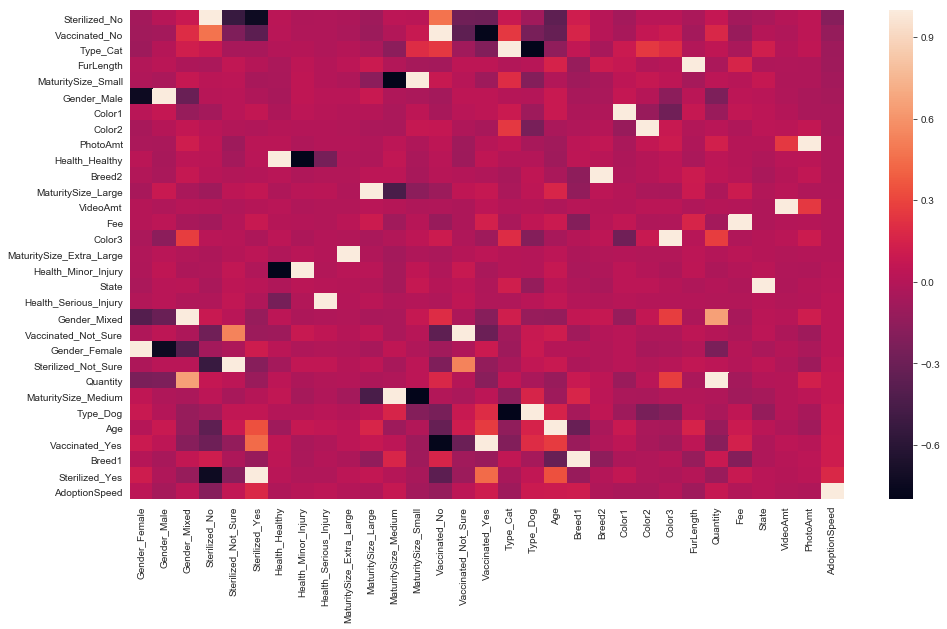

,Gender_Female,Gender_Male,Gender_Mixed,Sterilized_No,Sterilized_Not_Sure,Sterilized_Yes,Health_Healthy,Health_Minor_Injury,Health_Serious_Injury,MaturitySize_Extra_Large,...,Color1,Color2,Color3,FurLength,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
Sterilized_No,-0.07,0.01,0.09,1.00,-0.53,-0.74,0.03,-0.02,-0.02,-0.03,...,-0.06,0.02,0.02,-0.04,0.07,-0.07,-0.05,0.01,0.04,-0.19
Vaccinated_No,-0.08,-0.07,0.20,0.47,-0.22,-0.37,0.02,-0.01,-0.01,-0.04,...,-0.05,0.07,0.10,-0.07,0.17,-0.12,0.00,-0.01,0.04,-0.13
Type_Cat,-0.09,0.00,0.12,0.08,-0.05,-0.05,-0.00,0.00,-0.02,0.00,...,0.09,0.25,0.20,-0.01,0.05,-0.05,0.13,-0.00,0.05,-0.10
FurLength,-0.01,0.03,-0.03,-0.04,0.05,0.00,-0.04,0.04,-0.00,0.03,...,0.08,-0.01,0.01,1.00,-0.04,0.16,-0.03,-0.02,-0.03,-0.08
MaturitySize_Small,-0.02,-0.03,0.07,0.02,0.03,-0.05,-0.05,0.05,0.00,-0.02,...,0.04,0.08,0.04,-0.06,0.04,0.01,0.07,-0.02,-0.03,-0.07
Gender_Male,-0.74,1.00,-0.31,0.01,0.02,-0.02,-0.05,0.04,0.02,0.02,...,0.07,0.01,-0.16,0.03,-0.23,0.03,0.02,-0.02,-0.04,-0.06
Color1,0.02,0.07,-0.12,-0.06,0.02,0.06,-0.03,0.03,0.01,-0.00,...,1.00,-0.11,-0.28,0.08,-0.11,0.06,0.03,0.00,-0.04,-0.05
Color2,-0.05,0.01,0.06,0.02,-0.01,-0.01,0.00,-0.00,0.00,-0.01,...,-0.11,1.00,0.08,-0.01,0.02,-0.02,0.03,0.03,0.06,-0.04
PhotoAmt,-0.04,-0.04,0.12,0.04,-0.09,0.02,0.02,-0.02,-0.00,0.00,...,-0.04,0.06,0.10,-0.03,0.13,0.01,0.01,0.25,1.00,-0.02
Health_Healthy,0.02,-0.05,0.03,0.03,-0.07,0.02,1.00,-0.97,-0.25,-0.02,...,-0.03,0.00,0.03,-0.04,0.03,0.00,-0.03,0.02,0.02,-0.02


In [54]:

corr_matrix = newdf.corr()
corr_matrix = corr_matrix.sort_values(by='AdoptionSpeed')

plt.figure(figsize=(16,9))
sns.heatmap(corr_matrix, vmin= -0.8)
plt.show()

corr_matrix

In [67]:
# select the columns
X_columns = ['Age', 'Fee', 'Quantity','FurLength'] + list(dummies.columns)
y_column = ['AdoptionSpeed']

_____________
# Train the Model

In [68]:
# split the data using sklearn

df_train = newdf.copy()

threshold = 0.8
X = df_train[X_columns]
y = df_train[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold, shuffle=True, random_state =5)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (8000, 22)
y_train (8000, 1)
X_test (2000, 22)
y_test (2000, 1)


In [69]:
# train a KNN Classifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train.values.ravel())
knn_pred = knn_model.predict(X_test)

print(confusion_matrix(y_test, knn_pred))

[[  3   9  15  10   8]
 [  7 135 118  52  90]
 [  7 145 187  73 117]
 [  4 105 141  94 114]
 [  8 110 156  85 207]]


In [70]:

rf_model = RandomForestClassifier(100)
rf_model.fit(X_train, y_train.values.ravel())
rf_pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, rf_pred))

[[  3  13  12   7  10]
 [  7 112 149  63  71]
 [  8 112 188  88 133]
 [  6  70 133  98 151]
 [  7  75 149  86 249]]


_____________
# Model Evaluation

In [71]:
knn_kappa = cohen_kappa_score(y_test, knn_pred, weights ='quadratic')
print('kappa', round(knn_kappa, 4))
print(confusion_matrix(y_test, knn_pred))

kappa 0.1452
[[  3   9  15  10   8]
 [  7 135 118  52  90]
 [  7 145 187  73 117]
 [  4 105 141  94 114]
 [  8 110 156  85 207]]


In [72]:
rf_kappa = cohen_kappa_score(y_test, rf_pred, weights ='quadratic')
print('kappa', round(rf_kappa, 4))
print(confusion_matrix(y_test, rf_pred))

kappa 0.2215
[[  3  13  12   7  10]
 [  7 112 149  63  71]
 [  8 112 188  88 133]
 [  6  70 133  98 151]
 [  7  75 149  86 249]]


In [73]:
# Cross Validation

def cv(model):
    k = 10
    results = []
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_test)
        kappa = cohen_kappa_score(y_test, y_pred, weights ='quadratic')
        results.append(round(kappa, 4))

    print('Kappa for each fold:', results)
    print('AVG(kappa)', round(np.mean(results), 4))
    print('STD(kappa)', round(np.std(results), 4))

In [74]:
cv(knn_model)
cv(rf_model)

Kappa for each fold: [0.1654, 0.173, 0.1938, 0.1526, 0.1901, 0.1703, 0.2414, 0.2004, 0.1855, 0.1621]
AVG(kappa) 0.1835
STD(kappa) 0.0241
Kappa for each fold: [0.206, 0.2675, 0.1839, 0.1688, 0.2486, 0.1997, 0.2147, 0.2097, 0.2306, 0.1859]
AVG(kappa) 0.2115
STD(kappa) 0.0288


In [75]:

model = rf_model
fi = []

for i, col in enumerate(X_test.columns):
    fi.append([col, model.feature_importances_[i]])
    
pd.DataFrame(fi).sort_values(1, ascending=False)

,0,1
0,Age,0.40
1,Fee,0.15
2,Quantity,0.10
3,FurLength,0.10
5,Gender_Male,0.02
4,Gender_Female,0.02
7,Sterilized_No,0.02
15,MaturitySize_Medium,0.02
17,Vaccinated_No,0.02
19,Vaccinated_Yes,0.02


__________________
# Submission

In [ ]:
X_train = df_train[X_columns]
y_train = df_train[y_column]

df_prediction = newdf_test[X_columns]

In [ ]:

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train.values.ravel())
newdf_test['AdoptionSpeed'] = knn_model.predict(df_prediction)


In [ ]:
newdf_test[['PetID', 'AdoptionSpeed']].to_csv('submission_v1.csv', index=False)